**Notebook to get DEM from AIA data using Hannah & Kontar implementation**

@Author: David Long
@Editor: Mohamed Nedal

In [2]:
import warnings
warnings.simplefilter('ignore')

from sys import path as sys_path
import os.path
import platform
import datetime as dt
from aiapy.calibrate.prep import correct_degradation
import numpy as np
import glob
# import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits as fits
from sunpy.map import Map
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import propagate_with_solar_surface
import scipy.io as io
sys_path.append('/home/mnedal/repos/demreg/python')
from dn2dem_pos import dn2dem_pos
script_path = os.path.abspath('./scripts')
if script_path not in sys_path:
    sys_path.append(script_path)
from general_routines import closest
from aiapy.calibrate import register, update_pointing, estimate_error
import aiapy.psf
import asdf
from bisect import bisect_left, bisect_right
from sunpy.time import parse_time
from tqdm import tqdm

In [49]:
## Define constants and make the data directories
if platform.system() == 'Linux':
    data_disk = '/home/mnedal/data/AIA/'

os.makedirs(data_disk, exist_ok='True')

## Function with event information
start_time = '2024/05/14 17:00:00'
end_time   = '2024/05/14 19:00:00'

cadence = 10*u.second #seconds
img_time_range = [dt.datetime.strptime(start_time, "%Y/%m/%d %H:%M:%S"), dt.datetime.strptime(end_time, "%Y/%m/%d %H:%M:%S")]

ref_time = '2012/06/14 01:00:00'
bottom_left = [1381, 881]*u.pixel  
top_right   = [2215, 1881]*u.pixel  

ref_file_date = dt.datetime.strftime(dt.datetime.strptime(ref_time,'%Y/%m/%d %H:%M:%S'), '%Y/%m/%d')
img_file_date = dt.datetime.strftime(dt.datetime.strptime(ref_time,'%Y/%m/%d %H:%M:%S'), '%Y/%m/%d')

## Define and make the output directories
if platform.system() == 'Linux':
    output_dir = f'{data_disk}/DEM/{img_file_date}/'

os.makedirs(output_dir, exist_ok='True')
passband = [94, 131, 171, 193, 211, 335]

In [72]:
def get_filelist(data_disk, passband, img_file_date):
    """
    Function to get the list of AIA filenames.
    """
    files = glob.glob(data_disk+str(passband).rjust(4, "0")+'/'+img_file_date+'/*.fits', recursive=True)
    files.sort()
    files_dt = []
    for file_i in files:
        hdr = fits.getheader(file_i, 1)
        try:
            files_dt.append(dt.datetime.strptime(hdr.get('DATE-OBS'), '%Y-%m-%dT%H:%M:%S.%fZ'))
        except:
            files_dt.append(dt.datetime.strptime(hdr.get('DATE-OBS'), '%Y-%m-%dT%H:%M:%S.%f'))
    return files, files_dt

In [5]:
def get_data(start_time, end_time, img_file_date, cadence, pband, data_disk):
    """
    Function to download data.
    """
    # Identify and download the data
    attrs_time = a.Time(start_time, end_time)
    wvlnth = a.Wavelength(int(pband)*u.Angstrom, int(pband)*u.Angstrom)
    result = Fido.search(attrs_time, a.Instrument('AIA'), wvlnth, a.Sample(cadence))
    files = Fido.fetch(result, path=data_disk+str(pband).rjust(4, '0')+'/'+img_file_date, overwrite=False, progress=True)

In [40]:
def reduce_filerange(files_in, file_time_in, img_time_range):
    """
    Function to reduce filerange to within time range of interest.
    """
    left = bisect_left(file_time_in, img_time_range[0])
    right = bisect_right(file_time_in, img_time_range[1])
    files_out = files_in[left:right]
    file_time_out = file_time_in[left:right]
    return files_out, file_time_out

Get the data for the field of view reference

In [6]:
strt_time = dt.datetime.strptime(ref_time, "%Y/%m/%d %H:%M:%S")

files, files_dt = get_filelist(data_disk, 193, ref_file_date)
if not files:
    get_data(strt_time-dt.timedelta(seconds=10), strt_time+dt.timedelta(seconds=10), ref_file_date, 10*u.second, 193, data_disk)

files, files_dt = get_filelist(data_disk, 193, ref_file_date)

ind = np.abs([t - strt_time for t in files_dt])
map = Map(files[ind.argmin()])
    
pix_width = [(top_right[0]-bottom_left[0])/2, (top_right[1]-bottom_left[1])/2]
pix_centre = [pix_width[0]+bottom_left[0], pix_width[1]+bottom_left[1]]
crd_bl = SkyCoord(map.pixel_to_world(bottom_left[0], bottom_left[1]), frame=map.coordinate_frame)
crd_tr = SkyCoord(map.pixel_to_world(top_right[0], top_right[1]), frame=map.coordinate_frame)
    
crd_cent = SkyCoord(map.pixel_to_world(pix_centre[0], pix_centre[1]), frame=map.coordinate_frame)
crd_width = [(crd_tr.Tx.arcsecond-crd_bl.Tx.arcsecond)/2, (crd_tr.Ty.arcsecond-crd_bl.Ty.arcsecond)/2]

In [7]:
def get_submap(time_array, index, img, f_0171, crd_cent, crd_width):
    """
    Function to get AIA submap.
    """
    ind_0171 = closest(np.array(time_array[2][:]), time_array[index][img])
    map = Map(f_0171[ind_0171])
    with propagate_with_solar_surface():
        diffrot_cent = crd_cent.transform_to(map.coordinate_frame)
    bl = SkyCoord((diffrot_cent.Tx.arcsecond-crd_width[0])*u.arcsec, (diffrot_cent.Ty.arcsecond-crd_width[1])*u.arcsec, frame=map.coordinate_frame)
    tr = SkyCoord((diffrot_cent.Tx.arcsecond+crd_width[0])*u.arcsec, (diffrot_cent.Ty.arcsecond+crd_width[1])*u.arcsec, frame=map.coordinate_frame)
    submap = map.submap(bl, top_right=tr)
    return submap

In [8]:
def prep_images(time_array, index, img, f_0094, f_0131, f_0171, f_0193, f_0211, f_0335, crd_cent, crd_width):
    """
    Function to prep AIA images, deconvolve with PSF and produce submap.
    """
    ind_0094 = closest(np.array(time_array[0][:]), time_array[index][img])
    ind_0131 = closest(np.array(time_array[1][:]), time_array[index][img])
    ind_0171 = closest(np.array(time_array[2][:]), time_array[index][img])
    ind_0193 = closest(np.array(time_array[3][:]), time_array[index][img])
    ind_0211 = closest(np.array(time_array[4][:]), time_array[index][img])
    ind_0335 = closest(np.array(time_array[5][:]), time_array[index][img])

    farray = [f_0094[ind_0094], f_0131[ind_0131], f_0171[ind_0171], f_0193[ind_0193], f_0211[ind_0211], f_0335[ind_0335]]
    maps = Map(farray)
    with propagate_with_solar_surface():
        diffrot_cent = crd_cent.transform_to(maps[0].coordinate_frame)
    bl = SkyCoord((diffrot_cent.Tx.arcsecond-crd_width[0])*u.arcsec, (diffrot_cent.Ty.arcsecond-crd_width[1])*u.arcsec, frame=maps[0].coordinate_frame)
    bl_x, bl_y = maps[0].world_to_pixel(bl)
    tr = SkyCoord((diffrot_cent.Tx.arcsecond+crd_width[0])*u.arcsec, (diffrot_cent.Ty.arcsecond+crd_width[1])*u.arcsec, frame=maps[0].coordinate_frame)
    tr_x, tr_y = maps[0].world_to_pixel(tr)
    submap_0 = maps[0].submap([int(bl_x.value), int(bl_y.value)]*u.pixel, top_right=[int(tr_x.value), int(tr_y.value)]*u.pixel)
    nx, ny = submap_0.data.shape
    nf     = len(maps)

    print('Prepping images & deconvolving with PSF')
    map_arr = []
    error_array = np.zeros([nx, ny, nf])

    for m in range(0, len(maps)):
        psf = aiapy.psf.psf(maps[m].wavelength)
        aia_map_deconvolved = aiapy.psf.deconvolve(maps[m], psf=psf)
        aia_map_updated_pointing = update_pointing(aia_map_deconvolved)
        aia_map_registered = register(aia_map_updated_pointing)
        aia_map_corrected = correct_degradation(aia_map_registered)
        aia_map_norm = aia_map_corrected/aia_map_corrected.exposure_time
        submap = aia_map_norm.submap([int(bl_x.value), int(bl_y.value)]*u.pixel, top_right=[int(tr_x.value), int(tr_y.value)]*u.pixel)
        map_arr.append(submap)
        num_pix = submap.data.size
        error_array[:,:,m] = estimate_error(submap.data*(u.ct/u.pix), submap.wavelength, num_pix)

    map_array = Map(map_arr[0], map_arr[1], map_arr[2], map_arr[3],
                    map_arr[4], map_arr[5], sequence=True, sortby=None) 
    print('Images prepped & region of interest selected')
    return map_array, error_array

In [132]:
def calculate_dem(map_array, err_array):
    """
    Function to calculate DEM.
    """
    nx, ny = map_array[0].data.shape
    nf     = len(map_array)
    image_array = np.zeros((nx, ny, nf))
    for img in range(0, nf):
        image_array[:,:,img] = map_array[img].data
    
    if platform.system() == 'Linux':
        trin = io.readsav(f'{data_disk}/aia_tresp_en.dat')
        
    tresp_logt = np.array(trin['logt'])
    nt = len(tresp_logt)
    nf = len(trin['tr'][:])
    trmatrix = np.zeros((nt, nf))
    for i in range(0, nf):
        trmatrix[:,i] = trin['tr'][i]    
    
    t_space = 0.1
    t_min   = 5.6
    t_max   = 7.4
    logtemps = np.linspace(t_min, t_max, num=int((t_max-t_min)/t_space)+1)
    temps = 10**logtemps
    mlogt = ([np.mean([(np.log10(temps[i])), np.log10((temps[i+1]))]) for i in np.arange(0,len(temps)-1)])
    dem, edem, elogt, chisq, dn_reg = dn2dem_pos(image_array, err_array, trmatrix, tresp_logt, temps, max_iter=15)
    dem = dem.clip(min=0)
    return dem, edem, elogt, chisq, dn_reg, mlogt, logtemps

In [125]:
def plot_dem_images(submap, dem, logtemps, img_arr_tit):
    """
    Function to plot the DEM images.
    """
    nt = len(dem[0,0,:])
    nt_new = int(nt/2)
    nc, nr = 3, 3
    plt.rcParams.update({'font.size':12, 'font.family':"sans-serif",\
                         'font.sans-serif':"Arial", 'mathtext.default':"regular"})
    fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(10,12), sharex=True, sharey=True, subplot_kw=dict(projection=submap), layout='constrained')
    plt.suptitle('Image time = '+dt.datetime.strftime(submap.date.datetime, "%Y-%m-%dT%H:%M:%S"))
    fig.supxlabel('Solar X (arcsec)')
    fig.supylabel('Solar Y (arcsec)')
    cmap = plt.cm.get_cmap('cubehelix_r')

    for i, axi in enumerate(axes.flat):
        new_dem = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
        plotmap = Map(new_dem, submap.meta)
        plotmap.plot(axes=axi, norm=colors.LogNorm(vmin=1e19, vmax=1e22), cmap=cmap)
    
        y = axi.coords[1]
        y.set_axislabel(' ')
        if i == 1 or i == 2 or i == 4 or i == 5 or i == 7 or i == 8:
            y.set_ticklabel_visible(False)
        x = axi.coords[0]
        x.set_axislabel(' ')
        if i < 6:
            x.set_ticklabel_visible(False)

        axi.set_title(f'Log(T) = {logtemps[i*2]:.2f} - {logtemps[i*2+1+1]:.2f}')

    plt.tight_layout(pad=0.1, rect=[0, 0, 1, 0.98])
    plt.colorbar(ax=axes.ravel().tolist(), label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$', fraction=0.03, pad=0.02)
    plt.savefig(img_arr_tit, bbox_inches='tight')
    plt.close(fig)
    return

---

## START FROM HERE ...

---

In [ ]:
## Download the data
for pband in passband:
    files, file_time = get_filelist(data_disk, pband, img_file_date)
    left = bisect_left(file_time, img_time_range[0])
    right = bisect_right(file_time, img_time_range[1])
    n_img = ((img_time_range[1]-img_time_range[0]).total_seconds()/(cadence/u.second))

    if n_img > len(files[left:right]):
        print('Fewer than expected FITS files for '+str(pband).rjust(4, "0")+' passband')
        print('Downloading data for '+str(pband).rjust(4, "0")+' passband')
        get_data(start_time, end_time, img_file_date, cadence, pband, data_disk)
    else:
        print('Data already downloaded for '+str(pband).rjust(4, "0")+' passband')

In [ ]:
## Get list of files from each passband to identify the smallest number of files
print('Getting list of files')
f_0094, time_0094 = get_filelist(data_disk, 94, img_file_date)
f_0094, time_0094 = reduce_filerange(f_0094, time_0094, img_time_range)

f_0131, time_0131 = get_filelist(data_disk, 131, img_file_date)
f_0131, time_0131 = reduce_filerange(f_0131, time_0131, img_time_range)

f_0171, time_0171 = get_filelist(data_disk, 171, img_file_date)
f_0171, time_0171 = reduce_filerange(f_0171, time_0171, img_time_range)

f_0193, time_0193 = get_filelist(data_disk, 193, img_file_date)
f_0193, time_0193 = reduce_filerange(f_0193, time_0193, img_time_range)

f_0211, time_0211 = get_filelist(data_disk, 211, img_file_date)
f_0211, time_0211 = reduce_filerange(f_0211, time_0211, img_time_range)

f_0335, time_0335 = get_filelist(data_disk, 335, img_file_date)
f_0335, time_0335 = reduce_filerange(f_0335, time_0335, img_time_range)

flength = [len(f_0094), len(f_0131), len(f_0171), len(f_0193), len(f_0211), len(f_0335)]
flist = [f_0094, f_0131, f_0171, f_0193, f_0211, f_0335]
time_array = [time_0094, time_0131, time_0171, time_0193, time_0211, time_0335]
index = np.argmin(flength)

In [ ]:
# Begin image processing
start_img = closest(np.array(time_array[index][:]), dt.datetime.strptime(start_time, "%Y/%m/%d %H:%M:%S"))

for img in range(start_img, len(flist[index])):
    print('Processing image, time = '+dt.datetime.strftime(time_array[index][img], "%Y-%m-%dT%H:%M:%S"))

    # Get and process images.
    err_arr_tit = output_dir+'error_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.asdf'
    map_arr_tit = output_dir+'prepped_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'_{index:03}.fits'
    files = os.path.exists(err_arr_tit)
    
    if files == False:
        map_array, err_array = prep_images(time_array, index, img, f_0094, f_0131, f_0171, f_0193, f_0211, f_0335, crd_cent, crd_width)
        map_array.save(map_arr_tit, overwrite='True')
        tree = {'err_array': err_array}
        with asdf.AsdfFile(tree) as asdf_file:
            asdf_file.write_to(err_arr_tit, all_array_compression='zlib')
    else:
        print('Loading previously prepped images')
        arrs = asdf.open(err_arr_tit)
        err_array = arrs['err_array']
        ffin=sorted(glob.glob(output_dir+'prepped_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'*.fits'))
        map_array = Map(ffin)
    
    # Calculate DEMs
    dem_arr_tit = output_dir+'dem_data_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.asdf'
    files = os.path.exists(dem_arr_tit)
    
    if files == False:
        print('Calculating DEM')
        dem, edem, elogt, chisq, dn_reg, mlogt, logtemps = calculate_dem(map_array, err_array)
        tree = {'dem':dem, 'edem':edem, 'mlogt':mlogt, 'elogt':elogt, 'chisq':chisq, 'logtemps':logtemps}
        
        with asdf.AsdfFile(tree) as asdf_file:  
            asdf_file.write_to(dem_arr_tit, all_array_compression='zlib')
    else:
        print('Loading previously calculated DEM')
        arrs = asdf.open(dem_arr_tit)  
        dem = arrs['dem']
        edem = arrs['edem']
        mlogt = arrs['mlogt']
        elogt = arrs['elogt']
        chisq = arrs['chisq']
        logtemps = arrs['logtemps']

    # Plot results
#    img_tit = output_dir+'Centre_pixel_DEM_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
#    plot_dem(dem,edem,mlogt,elogt,img_tit)

    # Get a submap to have the scales and image properties.
    submap = get_submap(time_array, index, img, f_0171, crd_cent, crd_width)
    img_arr_tit = output_dir+'DEM_images_'+dt.datetime.strftime(time_array[index][img], "%Y%m%d_%H%M%S")+'.png'
    plot = plot_dem_images(submap, dem, logtemps, img_arr_tit)
    print('DEM plotted')

---

# My Attempts ...

---

In [6]:
def extract_datetime(filename, channel):
    """
    Function to extract the datetime from a filename.
    """
    # Split the filename and extract the date and time parts
    date_time_part = filename.split('/')[-1]                            # Extracts '2024_05_14T18_49_59.12'
    date_part = date_time_part.split('T')[0].split(f'{channel}A_')[-1]  # Extracts '2024_05_14'
    time_part = date_time_part.split('T')[1].split('Z')[0]              # Extracts '18_49_59.12'
    
    # Reformat date and time to standard datetime format
    date_str = date_part.replace('_', '-')  # '2024-05-14'
    time_str = time_part.replace('_', ':')  # '18:49:59.12'
    
    # Combine date and time and convert to datetime object
    return dt.datetime.strptime(f'{date_str} {time_str}', '%Y-%m-%d %H:%M:%S.%f')


def find_closest_filename(filenames, channel, target_datetime):
    """
    Function to find the index of the filename with the closest datetime to a given target.
    """
    closest_index = None
    min_time_diff = None
    
    for i, filename in enumerate(filenames):
        file_datetime = extract_datetime(filename, channel)
        
        # Calculate the absolute time difference
        time_diff = abs(file_datetime - target_datetime)
        
        # Update the closest file if this one is closer
        if min_time_diff is None or time_diff < min_time_diff:
            min_time_diff = time_diff
            closest_index = i
    
    return closest_index


def calculate_dem(map_array, err_array):
    """
    Function to calculate DEM.
    """
    nx, ny      = map_array[0].data.shape
    nf          = len(map_array)
    image_array = np.zeros((nx, ny, nf))
    for img in range(0, nf):
        image_array[:,:,img] = map_array[img].data
    
    if platform.system() == 'Linux':
        trin = io.readsav('/home/mnedal/data/aia_tresp_en.dat')
        
    tresp_logt = np.array(trin['logt'])
    nt         = len(tresp_logt)
    nf         = len(trin['tr'][:])
    trmatrix   = np.zeros((nt,nf))
    for i in range(0,nf):
        trmatrix[:,i] = trin['tr'][i]    
    
    t_space  = 0.1
    t_min    = 5.6
    t_max    = 7.4
    logtemps = np.linspace(t_min, t_max, num=int((t_max-t_min)/t_space)+1)
    temps    = 10**logtemps
    mlogt    = ([np.mean([(np.log10(temps[i])), np.log10((temps[i+1]))]) for i in np.arange(0, len(temps)-1)])
    dem, edem, elogt, chisq, dn_reg = dn2dem_pos(image_array, err_array, trmatrix, tresp_logt, temps, max_iter=15)
    dem = dem.clip(min=0)
    return dem, edem, elogt, chisq, dn_reg, mlogt, logtemps

In [179]:
date_time_str = '2024-05-14 17:36:05.0' # Your target date and time

target_datetime = dt.datetime.strptime(f'{date_time_str}', '%Y-%m-%d %H:%M:%S.%f')
passband = [94, 131, 171, 193, 211, 335]
data_dir = '/home/mnedal/data'

farray = []

for channel in passband:
    files = sorted(glob.glob(f'{data_dir}/AIA/{channel}A/highres/lv15/*.fits'))
    closest_index = find_closest_filename(files, channel, target_datetime)
    aia_file = files[closest_index]
    # m = Map(aia_file)
    farray.append(aia_file)

maps = Map(farray)

In [186]:
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=maps[0].coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=maps[0].coordinate_frame)
submap_0    = maps[0].submap(bottom_left, top_right=top_right)
nx, ny      = submap_0.data.shape
nf          = len(maps)
map_arr     = []
err_array = np.zeros([nx, ny, nf])

for i, m in enumerate(maps):
    # crop the region of interest
    top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    submap      = m.submap(bottom_left, top_right=top_right)
    map_arr.append(submap)
    
    num_pix = submap.data.size
    err_array[:,:,i] = estimate_error(submap.data*(u.ct/u.pix), submap.wavelength, n_samples=num_pix)

map_array = Map(map_arr[0], map_arr[1], map_arr[2],
                map_arr[3], map_arr[4], map_arr[5],
                sequence=True, sortby=None)
map_arr_tit = data_dir + '/tornado_files/prepped_data_{index:03}.fits'
map_array.save(map_arr_tit, overwrite='True')

err_arr_tit = f'{data_dir}/tornado_files/error_data.asdf'
tree = {'err_array': err_array}
with asdf.AsdfFile(tree) as asdf_file:
    asdf_file.write_to(err_arr_tit, all_array_compression='zlib')

In [177]:
# export prepped maps as asdf file
files = sorted(glob.glob(f'{data_dir}/tornado_files/*.fits'))
tree = {}
for i, file in enumerate(files):
    tree[f'image_array_{i}'] = Map(file)
with asdf.AsdfFile(tree) as asdf_file:
    asdf_file.write_to(f'{data_dir}/tornado_files/image_arrays.asdf', all_array_compression='zlib')

In [165]:
print('Diagnosis of input parameters')
print(f'image_array: {image_array.shape}')
print(f'err_array: {err_array.shape}')
print(f'trmatrix: {trmatrix.shape}')
print(f'tresp_logt: {tresp_logt.shape}')
print(f'temps: {temps.shape}')

Diagnosis of input parameters
image_array: (201, 134, 6)
err_array: (201, 134, 6)
trmatrix: (101, 6)
tresp_logt: (101,)
temps: (19,)


In [191]:
print('Calculating DEM ...')
dem, edem, elogt, chisq, dn_reg, mlogt, logtemps = calculate_dem(map_array, err_array)

tree = {'dem':dem, 'edem':edem, 'mlogt':mlogt, 'elogt':elogt, 'chisq':chisq, 'logtemps':logtemps}
dem_arr_tit = f'{data_dir}/tornado_files/dem_data.asdf'
with asdf.AsdfFile(tree) as asdf_file:
    asdf_file.write_to(dem_arr_tit, all_array_compression='zlib')

Exception ignored on calling ctypes callback function: <function _find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9c49792c20>
Traceback (most recent call last):
  File "/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/threadpoolctl.py", line 347, in match_module_callback
    _get_module_info_from_path(filepath, prefixes, user_api,
  File "/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/threadpoolctl.py", line 318, in _get_module_info_from_path
    modules.append(_make_module_info(filepath, info, prefix))
  File "/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/threadpoolctl.py", line 307, in _make_module_info
    version=_get_version(dynlib, internal_api))
  File "/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/threadpoolctl.py", line 229, in _get_version
    return _get_openblas_version(dynlib)
  File "/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/threadpoolctl.py", line 2

Calculating DEM ...


100%|████████████████████████████████████████████████████████| 269/269 [26:51<00:00, 5.99s/ x10^2 DEM]


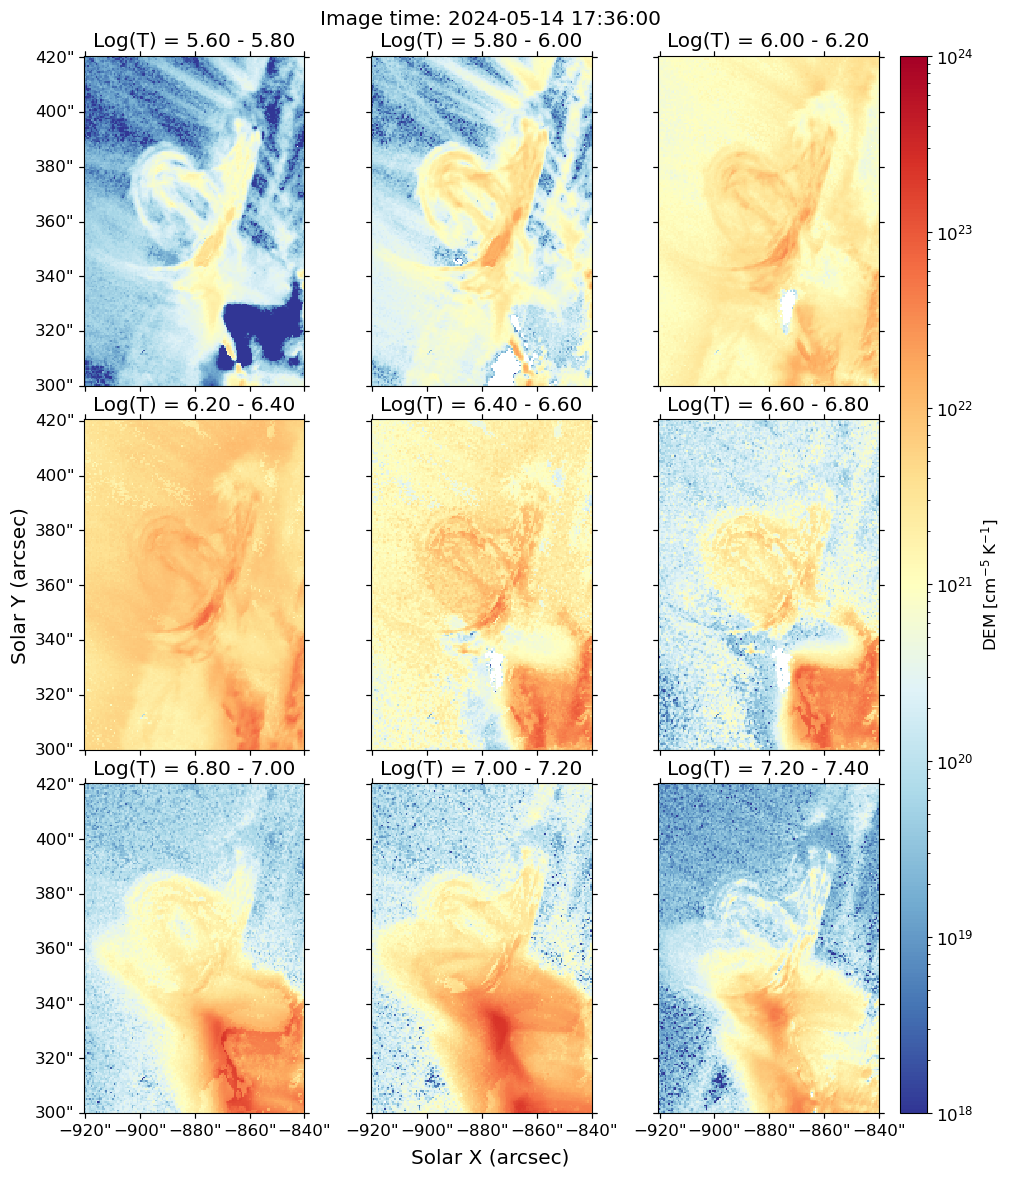

In [352]:
# Get a submap to have the scales and image properties
# img_arr_tit = f'{data_dir}/tornado_files/DEM_images.png'
# plot = plot_dem_images(submap_0, dem, logtemps, img_arr_tit)

nt     = len(dem[0,0,:])
nt_new = int(nt/2)
nc, nr = 3, 3
plt.rcParams.update({'font.size':12, 'font.family':"DejaVu Sans",\
                     'font.sans-serif':"DejaVu Sans", 'mathtext.default':"regular"})

fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=[12,12], sharex=True, sharey=True, subplot_kw=dict(projection=submap), layout='constrained')
plt.suptitle('Image time: '+dt.datetime.strftime(submap.date.datetime, "%Y-%m-%d %H:%M:%S"))
fig.supxlabel('Solar X (arcsec)', y=0.015)
fig.supylabel('Solar Y (arcsec)', x=0.1)
# cmap = plt.cm.get_cmap('cubehelix_r')

for i, axi in enumerate(axes.flat):
    new_dem = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
    plotmap = Map(new_dem, submap.meta)
    plotmap.plot(axes=axi,
                 # norm=colors.LogNorm(vmin=1e19, vmax=1e22),
                 norm=colors.LogNorm(vmin=1e18, vmax=1e24),
                 # cmap=cmap
                 cmap='RdYlBu_r'
                )
    axi.grid(False)
    
    y = axi.coords[1]
    y.set_axislabel(' ')
    if i == 1 or i == 2 or i == 4 or i == 5 or i == 7 or i == 8:
        y.set_ticklabel_visible(False)
    x = axi.coords[0]
    x.set_axislabel(' ')
    if i < 6:
        x.set_ticklabel_visible(False)

    axi.set_title(f'Log(T) = {logtemps[i*2]:.2f} - {logtemps[i*2+1+1]:.2f}')

fig.tight_layout(pad=0.1, rect=[0, 0, 1, 0.98])
plt.colorbar(ax=axes.ravel().tolist(), label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$', 
             # fraction=0.03,
             aspect=40,
             pad=0.02)
# fig.savefig(f'{data_dir}/tornado_files/dem_tornado.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'{data_dir}/png/tornado/dem_tornado.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Path to the directory
path     = f'{data_dir}/tornado_files'
folder   = '20240514T173601'
arrs     = asdf.open(f'{data_dir}/tornado_files/{folder}/dem_data_{folder}.asdf')
dem      = arrs['dem']
logtemps = arrs['logtemps']

i = 0
new_dem1  = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
plotmap1  = Map(new_dem1, submap.meta)
logtemps1 = [ logtemps[i*2], logtemps[i*2+1+1] ]

i = 4
new_dem2  = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
plotmap2  = Map(new_dem2, submap.meta)
logtemps2 = [ logtemps[i*2], logtemps[i*2+1+1] ]

i = 8
new_dem3  = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
plotmap3  = Map(new_dem3, submap.meta)
logtemps3 = [ logtemps[i*2], logtemps[i*2+1+1] ]

dem_maps    = [plotmap1, plotmap2, plotmap3]
logtemps_v2 = [logtemps1, logtemps2, logtemps3]

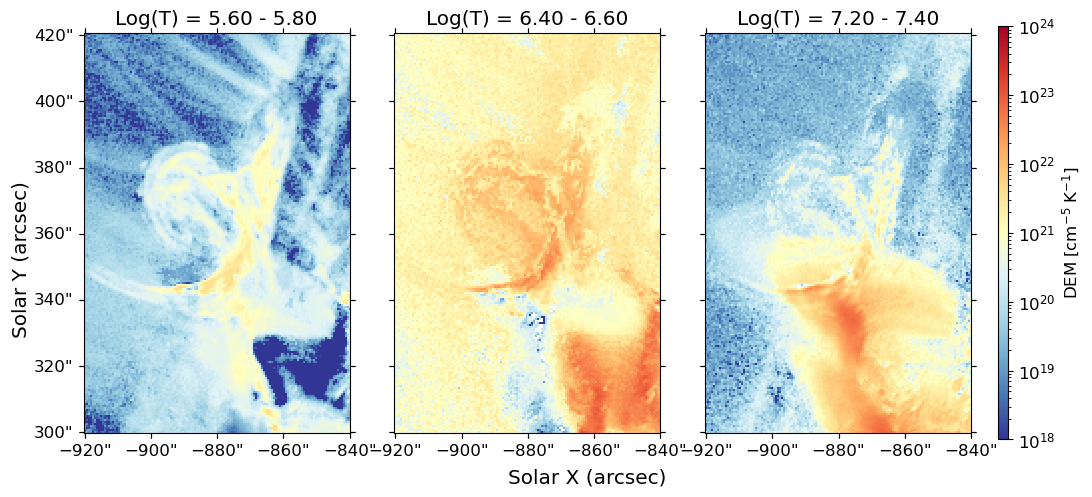

In [527]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[12,7], sharex=True, sharey=True, subplot_kw=dict(projection=submap), layout='constrained')
# plt.suptitle(dt.datetime.strftime(submap.date.datetime, "%Y-%m-%d %H:%M:%S"), y=0.88)
fig.supxlabel('Solar X (arcsec)', y=0.175)
fig.supylabel('Solar Y (arcsec)', x=0.02)

for i, axi in enumerate(axes.flat):
    dem_maps[i].plot(axes=axi,
                 norm=colors.LogNorm(vmin=1e18, vmax=1e24),
                 cmap='RdYlBu_r')
    axi.grid(False)
    y = axi.coords[1]
    if i != 0:
        y.set_axislabel(' ')
        y.set_ticklabel_visible(False)
    else:
        y.set_axislabel(' ')
        # axi.set_ylabel('Solar Y (arcsec)')
    x = axi.coords[0]
    x.set_axislabel(' ')
    # x.set_ticklabel_visible(False)
    axi.set_title(f'Log(T) = {logtemps_v2[i][0]:.2f} - {logtemps_v2[i][1]:.2f}')

fig.tight_layout(pad=0.1, rect=[0, 0, 1, 0.98])
plt.colorbar(ax=axes.ravel().tolist(), label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$', 
             shrink=0.68, aspect=40, pad=0.025)
# fig.savefig(f'{data_dir}/tornado_files/dem_tornado.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/png/tornado/dem_tornado.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [467]:
# # Plot only specific maps for the paper
# plt.rcParams.update({'font.size':12, 'font.family':"DejaVu Sans",\
#                      'font.sans-serif':"DejaVu Sans", 'mathtext.default':"regular"})

# indices = [0, 4, 8]

# fig = plt.figure(figsize=[12,6], layout='constrained')
# fig.suptitle('Image time: '+dt.datetime.strftime(submap.date.datetime, "%Y-%m-%d %H:%M:%S"))
# fig.supxlabel('Solar X (arcsec)', y=0.015)
# fig.supylabel('Solar Y (arcsec)', x=0.1)

# i = 0
# ax = fig.add_subplot(131)
# new_dem = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
# plotmap = Map(new_dem, submap.meta)
# plotmap.plot(axes=ax,
#              norm=colors.LogNorm(vmin=1e18, vmax=1e24),
#              cmap='RdYlBu_r')
# ax.grid(False)
# y = ax.coords[1]
# y.set_axislabel(' ')
# y.set_ticklabel_visible(False)
# x = ax.coords[0]
# x.set_axislabel(' ')
# x.set_ticklabel_visible(False)
# ax.set_title(f'Log(T) = {logtemps[i*2]:.2f} - {logtemps[i*2+1+1]:.2f}')



# fig.tight_layout(pad=0.1, rect=[0, 0, 1, 0.98])
# plt.colorbar(ax=axes.ravel().tolist(), label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$', 
#              shrink=0.8, aspect=40, pad=0.02)
# # fig.savefig(f'{data_dir}/tornado_files/dem_tornado.pdf', format='pdf', bbox_inches='tight')
# # fig.savefig(f'{data_dir}/png/tornado/dem_tornado.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

In [242]:
# Load and plot DEM saved run
# arrs = asdf.open('/home/mnedal/data/tornado_files/20240514T173701/dem_data_20240514T173701.asdf')  
# dem = arrs['dem']
# edem = arrs['edem']
# mlogt = arrs['mlogt']
# elogt = arrs['elogt']
# chisq = arrs['chisq']
# logtemps = arrs['logtemps']

# # Get a submap to have the scales and image properties
# nt     = len(dem[0,0,:])
# nt_new = int(nt/2)
# nc, nr = 3, 3
# plt.rcParams.update({'font.size':12, 'font.family':"DejaVu Sans",\
#                      'font.sans-serif':"DejaVu Sans", 'mathtext.default':"regular"})

# fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=[12,12], sharex=True, sharey=True, subplot_kw=dict(projection=submap), layout='constrained')
# plt.suptitle('Image time: '+dt.datetime.strftime(submap.date.datetime, "%Y-%m-%d %H:%M:%S"))
# fig.supxlabel('Solar X (arcsec)', y=0.015)
# fig.supylabel('Solar Y (arcsec)', x=0.1)
# cmap = plt.cm.get_cmap('cubehelix_r')

# for i, axi in enumerate(axes.flat):
#     new_dem = (dem[:,:,i*2]+dem[:,:,i*2+1])/2.
#     plotmap = Map(new_dem, submap.meta)
#     plotmap.plot(axes=axi,
#                  norm=colors.LogNorm(vmin=1e18, vmax=1e24),
#                  cmap='RdYlBu_r')
#     axi.grid(False)
    
#     y = axi.coords[1]
#     y.set_axislabel(' ')
#     if i == 1 or i == 2 or i == 4 or i == 5 or i == 7 or i == 8:
#         y.set_ticklabel_visible(False)
#     x = axi.coords[0]
#     x.set_axislabel(' ')
#     if i < 6:
#         x.set_ticklabel_visible(False)

#     axi.set_title(f'Log(T) = {logtemps[i*2]:.2f} - {logtemps[i*2+1+1]:.2f}')

# fig.tight_layout(pad=0.1, rect=[0, 0, 1, 0.98])
# plt.colorbar(ax=axes.ravel().tolist(), label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$', 
#              aspect=40, pad=0.02)
# fig.savefig(f'{data_dir}/tornado_files/{frame_folder}/dem_tornado_{frame_folder}.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/tornado_files/png/dem_tornado_{frame_folder}.png', format='png', dpi=300, bbox_inches='tight')
# plt.close()

In [528]:
def make_datetime_range(start_time=None, end_time=None, cadence=None):
    """
    Make a list of datetime strings between two given datetime strings.
    Cadence is in seconds.
    """
    from datetime import datetime, timedelta
    
    # Given start and end times
    st = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S.%f')
    et = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S.%f')
    
    # Create list of datetime strings with 12-second cadence
    datetime_list = []
    current_time = st
    
    while current_time <= et:
        datetime_list.append(current_time.strftime('%Y-%m-%d %H:%M:%S.%f'))
        current_time += timedelta(seconds=cadence)
    
    return datetime_list

In [529]:
datetime_list = make_datetime_range(start_time='2024-05-14 17:00:00.00',
                                    end_time='2024-05-14 19:00:00.00',
                                    cadence=12)
len(datetime_list)

601

## Calculate Temperature Map

In [7]:
# Load the corresponding AIA map to use its meta data
date_time_str = '2024-05-14 17:36:01.0'
passband = 193
target_datetime = dt.datetime.strptime(f'{date_time_str}', '%Y-%m-%d %H:%M:%S.%f')
data_dir = '/home/mnedal/data'

files = sorted(glob.glob(f'{data_dir}/AIA/{passband}A/highres/lv15/*.fits'))
closest_index = find_closest_filename(files, passband, target_datetime)
aia_file = files[closest_index]
m = Map(aia_file)
# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
submap      = m.submap(bottom_left, top_right=top_right)

# submap.peek()

In [8]:
# Path to the directory
path = f'{data_dir}/tornado_files'
# List all folders in the directory
# folders = sorted([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('2024')])
folder   = '20240514T173601'
arrs     = asdf.open(f'{data_dir}/tornado_files/{folder}/dem_data_{folder}.asdf')
dem      = arrs['dem']
logtemps = arrs['logtemps']

In [542]:
# # Assume you have the DEM data and corresponding temperature bins
# temp_kelvin = 10**logtemps  # Convert log(T) to Kelvin
# # DEM data is a 3D array (temperature bins x pixel_x x pixel_y)
# # Calculate temperature map
# weighted_temp = np.sum(temp_kelvin[:-1, np.newaxis, np.newaxis] * dem, axis=0)
# total_dem = np.sum(dem, axis=0)
# temp_map = weighted_temp / total_dem

In [9]:
# Convert log temperatures to Kelvin
temp_kelvin = 10**logtemps  # Shape (19,)

# Reshape temp_kelvin to be broadcastable with the dem array (201, 134, 18)
# Skip the last temperature bin as you are doing with temp_kelvin[:-1]
temp_kelvin = temp_kelvin[:-1].reshape(1, 1, -1)  # Shape becomes (1, 1, 18)

# Now you can multiply temp_kelvin with dem
weighted_temp = np.sum(temp_kelvin * dem, axis=2)  # Summing over the temperature axis (the last dimension)

# Calculate total DEM across all temperature bins
total_dem = np.sum(dem, axis=2)

# Calculate temperature map
temp_map = weighted_temp / total_dem

# Handle division by zero (in case some pixels have zero DEM)
# temp_map[np.isnan(temp_map)] = 0  # Replace NaNs with 0, or use any appropriate value

plottemp = Map(temp_map, submap.meta)

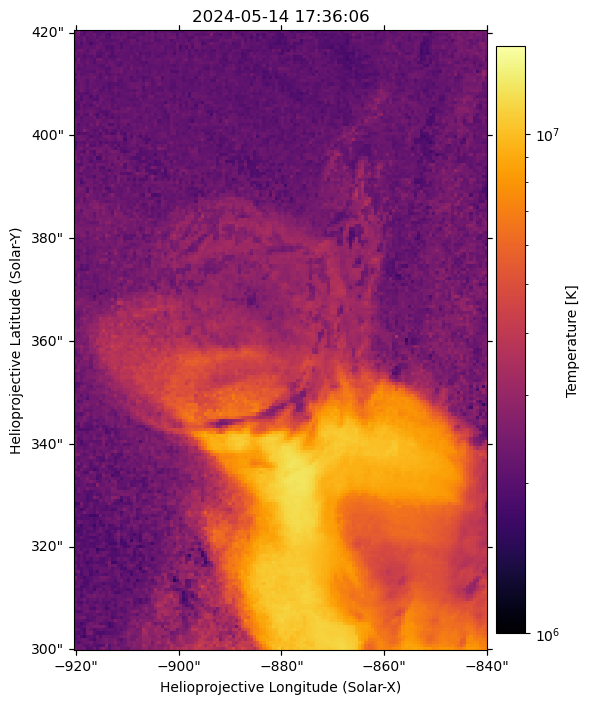

In [10]:
fig = plt.figure(figsize=[6,8])
ax = fig.add_subplot(projection=plottemp)
img = plottemp.plot(axes=ax,
                    norm=colors.LogNorm(vmin=1e6, vmax=1.5e7),
                    # norm=colors.LogNorm(vmin=10**5.6, vmax=10**7.4),
                    cmap='inferno') # nipy_spectral, gist_ncar, turbo, hsv, jet, Spectral_r, plasma, inferno
plt.colorbar(img, fraction=0.065, pad=0.02, label='Temperature [K]')
ax.grid(False)
ax.set_title(plottemp.latex_name.split('}$ ')[-1])
fig.tight_layout()
# fig.savefig(f'{data_dir}/temp_tornado.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/png/tornado/temp_tornado.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [513]:
# Do it for all timesteps
print('Loading previously calculated DEMs ..')
os.makedirs(f'{data_dir}/png/tornado/temp_dem', exist_ok='True')
os.makedirs(f'{data_dir}/tornado_files/temp_dem_fits', exist_ok='True')

# Path to the directory
path = f'{data_dir}/tornado_files'
# List all folders in the directory
folders = sorted([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('2024')])

with tqdm(total=len(folders), desc=f'Exporting DEM-temp maps ...') as pbar:
    for folder in folders:
        ### update the obs-date in the map's meta data
        # Parse it into a datetime object
        parsed_datetime = datetime.strptime(folder, '%Y%m%dT%H%M%S')
        # Format it into the desired string format
        formatted_datetime = parsed_datetime.strftime('%Y-%m-%dT%H:%M:%S.00')
        submap.meta['date-obs'] = formatted_datetime

        # load the DEM outputs
        arrs     = asdf.open(f'{data_dir}/tornado_files/{folder}/dem_data_{folder}.asdf')
        dem      = arrs['dem']
        # edem     = arrs['edem']
        # mlogt    = arrs['mlogt']
        # elogt    = arrs['elogt']
        # chisq    = arrs['chisq']
        logtemps = arrs['logtemps']
        
        # Convert log temperatures to Kelvin
        temp_kelvin = 10**logtemps  # Shape (19,)
        # Reshape temp_kelvin to be broadcastable with the dem array (201, 134, 18)
        # Skip the last temperature bin as you are doing with temp_kelvin[:-1]
        temp_kelvin = temp_kelvin[:-1].reshape(1, 1, -1)  # Shape becomes (1, 1, 18)
        
        # Now you can multiply temp_kelvin with dem
        weighted_temp = np.sum(temp_kelvin * dem, axis=2) # Summing over the temperature axis (the last dimension)
        # Calculate total DEM across all temperature bins
        total_dem = np.sum(dem, axis=2)
        # Calculate temperature map
        temp_map = weighted_temp / total_dem
        plottemp = Map(temp_map, submap.meta)
        
        map_arr_title = f'{data_dir}/tornado_files/temp_dem_fits/{folder}.fits'
        # if not os.path.exists(map_arr_title):
        #     plottemp.save(map_arr_title, overwrite='True')
        
        # img_title = f'{data_dir}/png/tornado/temp_dem/{folder}.png'
        # if not os.path.exists(img_title):
        #     fig = plt.figure(figsize=[6,8])
        #     ax = fig.add_subplot(projection=plottemp)
        #     img = plottemp.plot(axes=ax,
        #                         norm=colors.LogNorm(vmin=1e6, vmax=1.5e7),
        #                         cmap='inferno')
        #     plt.colorbar(img, fraction=0.065, pad=0.02, label='Temperature [K]')
        #     ax.grid(False)
        #     ax.set_title(str(datetime.strptime(folder, '%Y%m%dT%H%M%S')))
        #     fig.tight_layout()
        #     fig.savefig(f'{img_title}', format='png', dpi=300, bbox_inches='tight')
        #     plt.close()

        plottemp.save(map_arr_title, overwrite='True')
        img_title = f'{data_dir}/png/tornado/temp_dem/{folder}.png'
        fig = plt.figure(figsize=[6,8])
        ax = fig.add_subplot(projection=plottemp)
        img = plottemp.plot(axes=ax,
                            norm=colors.LogNorm(vmin=1e6, vmax=1.5e7),
                            cmap='inferno')
        plt.colorbar(img, fraction=0.065, pad=0.02, label='Temperature [K]')
        ax.grid(False)
        ax.set_title(str(datetime.strptime(folder, '%Y%m%dT%H%M%S')))
        fig.tight_layout()
        fig.savefig(f'{img_title}', format='png', dpi=300, bbox_inches='tight')
        plt.close()
        
        pbar.update(1)

Loading previously calculated DEMs ..


Exporting DEM-temp maps ...: 100%|██████████████████████████████████| 558/558 [28:33<00:00,  3.07s/it]


## Calculate Density

In [11]:
# L = 1e8  # Assume line-of-sight depth in cm
# L = 1.84e10 # this is the whole length of the vortex taken as the sum of the segments lengths, which is too much!
L = 2.24e9 # est. diameter of the loop in cm.

# Total DEM over all temperature bins
total_dem = np.sum(dem, axis=2)  # Summing over temperature bins

# Calculate density map
density_map = np.sqrt(total_dem / L)

plotdens = Map(density_map, submap.meta)

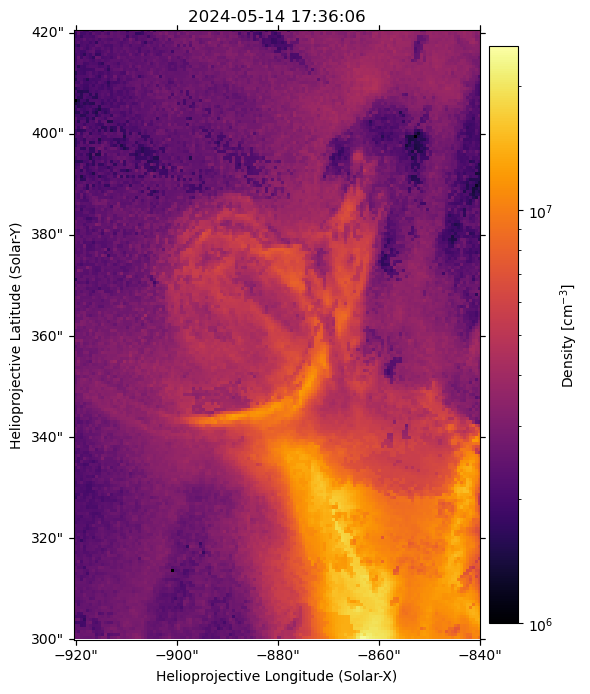

In [12]:
fig = plt.figure(figsize=[6,8])
ax  = fig.add_subplot(projection=plotdens)
img = plotdens.plot(axes=ax,
                    norm=colors.LogNorm(vmin=1e6, vmax=2.5e7),
                    # norm=colors.LogNorm(vmin=10**5.6, vmax=10**7.4),
                    cmap='inferno') # nipy_spectral, gist_ncar, turbo, hsv, jet, Spectral_r
plt.colorbar(img, fraction=0.065, pad=0.02, label=r'Density [cm$^{-3}$]')
ax.grid(False)
ax.set_title(plotdens.latex_name.split('}$ ')[-1])
fig.tight_layout()
# fig.savefig(f'{data_dir}/dens_tornado.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/png/tornado/dens_tornado.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [516]:
# Do it for all timesteps
print('Loading previously calculated DEMs ..')
os.makedirs(f'{data_dir}/png/tornado/dens_dem', exist_ok='True')
os.makedirs(f'{data_dir}/tornado_files/dens_dem_fits', exist_ok='True')

# Path to the directory
path = f'{data_dir}/tornado_files'
# List all folders in the directory
folders = sorted([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('2024')])

with tqdm(total=len(folders), desc=f'Exporting DEM-dens maps ...') as pbar:
    for folder in folders:
        ### update the obs-date in the map's meta data
        # Parse it into a datetime object
        parsed_datetime = datetime.strptime(folder, '%Y%m%dT%H%M%S')
        # Format it into the desired string format
        formatted_datetime = parsed_datetime.strftime('%Y-%m-%dT%H:%M:%S.00')
        submap.meta['date-obs'] = formatted_datetime
        
        # load the DEM outputs
        arrs     = asdf.open(f'{data_dir}/tornado_files/{folder}/dem_data_{folder}.asdf')
        dem      = arrs['dem']
        # edem     = arrs['edem']
        # mlogt    = arrs['mlogt']
        # elogt    = arrs['elogt']
        # chisq    = arrs['chisq']
        logtemps = arrs['logtemps']
        
        # Convert log temperatures to Kelvin
        temp_kelvin = 10**logtemps  # Shape (19,)
        # Reshape temp_kelvin to be broadcastable with the dem array (201, 134, 18)
        # Skip the last temperature bin as you are doing with temp_kelvin[:-1]
        temp_kelvin = temp_kelvin[:-1].reshape(1, 1, -1)  # Shape becomes (1, 1, 18)
        
        # Now you can multiply temp_kelvin with dem
        weighted_temp = np.sum(temp_kelvin * dem, axis=2) # Summing over the temperature axis (the last dimension)
        # Calculate total DEM across all temperature bins
        total_dem = np.sum(dem, axis=2)
        # L = 1.84e10 # this is the whole length of the vortex taken as the sum of the segments lengths, which is too much!
        L = 2.24e9 # est. diameter of the loop i cm.
        # Total DEM over all temperature bins
        total_dem = np.sum(dem, axis=2)  # Summing over temperature bins
        # Calculate density map
        density_map = np.sqrt(total_dem / L)
        plotdens = Map(density_map, submap.meta)
        
        map_arr_title = f'{data_dir}/tornado_files/dens_dem_fits/{folder}.fits'
        # if not os.path.exists(map_arr_title):
        #     plotdens.save(map_arr_title, overwrite='True')
        
        # img_title = f'{data_dir}/png/tornado/dens_dem/{folder}.png'
        # if not os.path.exists(img_title):
        #     fig = plt.figure(figsize=[6,8])
        #     ax = fig.add_subplot(projection=plotdens)
        #     img = plotdens.plot(axes=ax,
        #                         norm=colors.LogNorm(vmin=4e5, vmax=1e7),
        #                         cmap='inferno')
        #     plt.colorbar(img, fraction=0.065, pad=0.02, label=r'Density [cm$^{-3}$]')
        #     ax.grid(False)
        #     ax.set_title(str(datetime.strptime(folder, '%Y%m%dT%H%M%S')))
        #     fig.tight_layout()
        #     fig.savefig(f'{img_title}', format='png', dpi=300, bbox_inches='tight')
        #     plt.close()
        
        plotdens.save(map_arr_title, overwrite='True')
        img_title = f'{data_dir}/png/tornado/dens_dem/{folder}.png'
        fig = plt.figure(figsize=[6,8])
        ax = fig.add_subplot(projection=plotdens)
        img = plotdens.plot(axes=ax,
                            norm=colors.LogNorm(vmin=4e5, vmax=1e7),
                            cmap='inferno')
        plt.colorbar(img, fraction=0.065, pad=0.02, label=r'Density [cm$^{-3}$]')
        ax.grid(False)
        ax.set_title(str(datetime.strptime(folder, '%Y%m%dT%H%M%S')))
        fig.tight_layout()
        fig.savefig(f'{img_title}', format='png', dpi=300, bbox_inches='tight')
        plt.close()
        
        pbar.update(1)

Loading previously calculated DEMs ..


Exporting DEM-dens maps ...: 100%|██████████████████████████████████| 558/558 [28:35<00:00,  3.07s/it]


### Updated Fig.

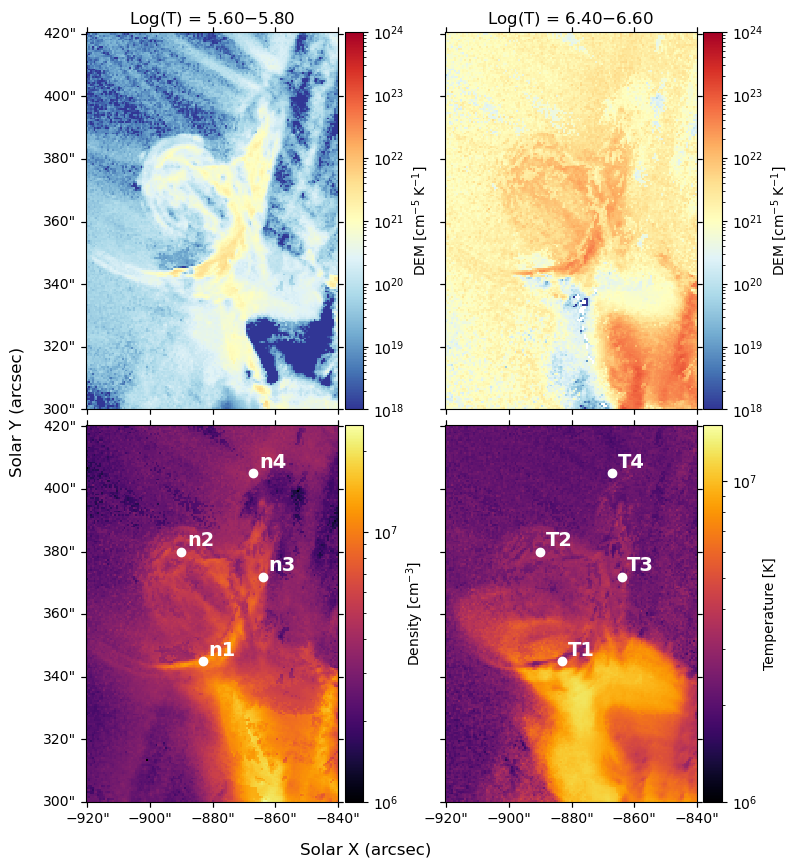

In [15]:
n_points = {
    'n1': [-883*u.arcsec, 345*u.arcsec],
    'n2': [-890*u.arcsec, 380*u.arcsec],
    'n3': [-864*u.arcsec, 372*u.arcsec],
    'n4': [-867*u.arcsec, 405*u.arcsec]
}

T_points = {
    'T1': [-883*u.arcsec, 345*u.arcsec],
    'T2': [-890*u.arcsec, 380*u.arcsec],
    'T3': [-864*u.arcsec, 372*u.arcsec],
    'T4': [-867*u.arcsec, 405*u.arcsec]
}

fig = plt.figure(figsize=[9,10])
fig.supxlabel('Solar X (arcsec)', y=0.055)
fig.supylabel('Solar Y (arcsec)', x=0.105)

ax = fig.add_subplot(221, projection=plotmap1)
plotmap1.plot(axes=ax,
             norm=colors.LogNorm(vmin=1e18, vmax=1e24),
             cmap='RdYlBu_r')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
x.set_ticklabel_visible(False)
y = ax.coords[1]
y.set_axislabel(' ')
# y.set_ticklabel_visible(False)
ax.set_title(rf'Log(T) = {logtemps1[0]:.2f}$-${logtemps1[1]:.2f}')
plt.colorbar(ax=ax, label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$',
             fraction=0.065, pad=0.02)

ax = fig.add_subplot(222, projection=plotmap2)
plotmap2.plot(axes=ax,
             norm=colors.LogNorm(vmin=1e18, vmax=1e24),
             cmap='RdYlBu_r')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
x.set_ticklabel_visible(False)
y = ax.coords[1]
y.set_axislabel(' ')
y.set_ticklabel_visible(False)
ax.set_title(rf'Log(T) = {logtemps2[0]:.2f}$-${logtemps2[1]:.2f}')
plt.colorbar(ax=ax, label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$',
             fraction=0.065, pad=0.02)

ax  = fig.add_subplot(223, projection=plotdens)
plotdens.plot(axes=ax,
              norm=colors.LogNorm(vmin=1e6, vmax=2.5e7),
              cmap='inferno')
for n_point in n_points:
    point_d_coord = SkyCoord(n_points[n_point][0], n_points[n_point][1], frame=plotdens.coordinate_frame)
    xd_pixel, yd_pixel = plotdens.wcs.world_to_pixel(point_d_coord)
    ax.plot(xd_pixel, yd_pixel, 'wo')
    ax.text(xd_pixel+3, yd_pixel+3, n_point, color='w', fontsize=14, weight='bold')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
# x.set_ticklabel_visible(False)
y = ax.coords[1]
y.set_axislabel(' ')
# y.set_ticklabel_visible(False)
ax.set_title('')
plt.colorbar(ax=ax, fraction=0.065, pad=0.02, label=r'Density [cm$^{-3}$]')

ax  = fig.add_subplot(224, projection=plottemp)
plottemp.plot(axes=ax,
              norm=colors.LogNorm(vmin=1e6, vmax=1.5e7),
              cmap='inferno')
for T_point in T_points:
    point_t_coord = SkyCoord(T_points[T_point][0], T_points[T_point][1], frame=plottemp.coordinate_frame)
    xt_pixel, yt_pixel = plottemp.wcs.world_to_pixel(point_t_coord)
    ax.plot(xt_pixel, yt_pixel, 'wo')
    ax.text(xt_pixel+3, yt_pixel+3, T_point, color='w', fontsize=14, weight='bold')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
# x.set_ticklabel_visible(False)
y = ax.coords[1]
y.set_axislabel(' ')
y.set_ticklabel_visible(False)
ax.set_title('')
plt.colorbar(ax=ax, fraction=0.065, pad=0.02, label='Temperature [K]')

plt.subplots_adjust(wspace=0.06, hspace=0.04)
# fig.savefig(f'{data_dir}/tornado_files/dem_tornado.pdf', format='pdf', bbox_inches='tight')
plt.show()

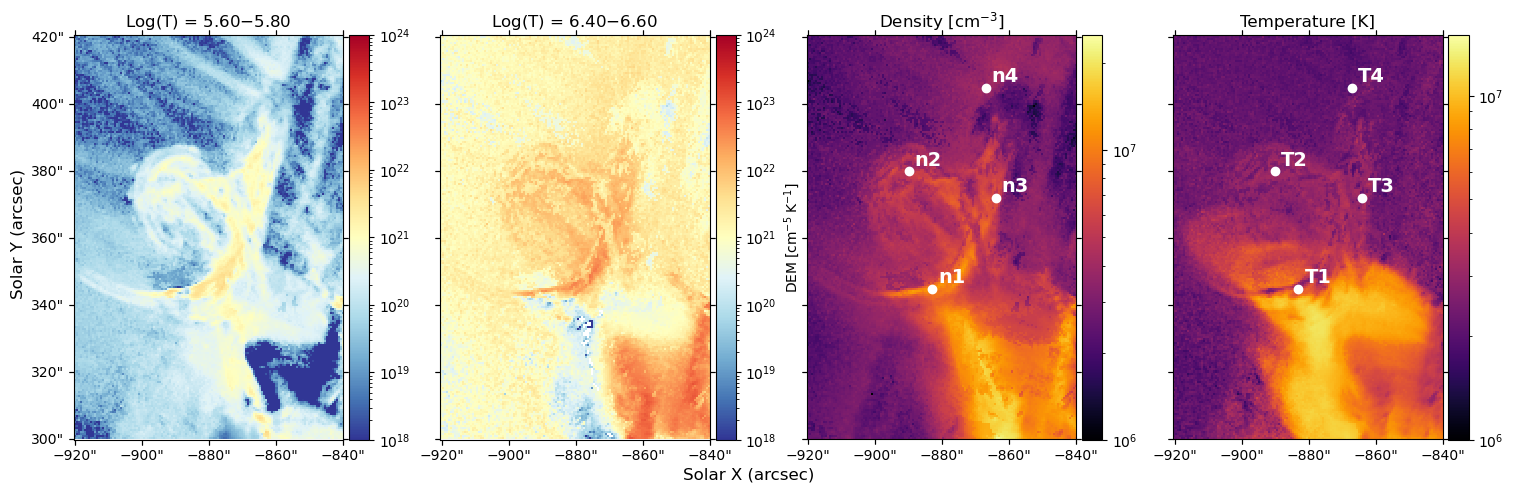

In [64]:
fig = plt.figure(figsize=[18,7])
fig.supxlabel('Solar X (arcsec)', y=0.145)
fig.supylabel('Solar Y (arcsec)', x=0.09)

ax = fig.add_subplot(141, projection=plotmap1)
plotmap1.plot(axes=ax,
             norm=colors.LogNorm(vmin=1e18, vmax=1e24),
             cmap='RdYlBu_r')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
y = ax.coords[1]
y.set_axislabel(' ')
ax.set_title(rf'Log(T) = {logtemps1[0]:.2f}$-${logtemps1[1]:.2f}')
# plt.colorbar(ax=ax, label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$',
#              fraction=0.0685, pad=0.02)
plt.colorbar(ax=ax, fraction=0.0685, pad=0.02)

ax = fig.add_subplot(142, projection=plotmap2)
plotmap2.plot(axes=ax,
             norm=colors.LogNorm(vmin=1e18, vmax=1e24),
             cmap='RdYlBu_r')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
y = ax.coords[1]
y.set_axislabel(' ')
y.set_ticklabel_visible(False)
ax.set_title(rf'Log(T) = {logtemps2[0]:.2f}$-${logtemps2[1]:.2f}')
plt.colorbar(ax=ax, label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$',
             fraction=0.0685, pad=0.02)

ax  = fig.add_subplot(143, projection=plotdens)
plotdens.plot(axes=ax,
              norm=colors.LogNorm(vmin=1e6, vmax=2.5e7),
              cmap='inferno')
for n_point in n_points:
    point_d_coord = SkyCoord(n_points[n_point][0], n_points[n_point][1], frame=plotdens.coordinate_frame)
    xd_pixel, yd_pixel = plotdens.wcs.world_to_pixel(point_d_coord)
    ax.plot(xd_pixel, yd_pixel, 'wo')
    ax.text(xd_pixel+3, yd_pixel+3, n_point, color='w', fontsize=14, weight='bold')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
y = ax.coords[1]
y.set_axislabel(' ')
y.set_ticklabel_visible(False)
ax.set_title(r'Density [cm$^{-3}$]')
plt.colorbar(ax=ax, fraction=0.0685, pad=0.02)

ax  = fig.add_subplot(144, projection=plottemp)
plottemp.plot(axes=ax,
              norm=colors.LogNorm(vmin=1e6, vmax=1.5e7),
              cmap='inferno')
for T_point in T_points:
    point_t_coord = SkyCoord(T_points[T_point][0], T_points[T_point][1], frame=plottemp.coordinate_frame)
    xt_pixel, yt_pixel = plottemp.wcs.world_to_pixel(point_t_coord)
    ax.plot(xt_pixel, yt_pixel, 'wo')
    ax.text(xt_pixel+3, yt_pixel+3, T_point, color='w', fontsize=14, weight='bold')
ax.grid(False)
x = ax.coords[0]
x.set_axislabel(' ')
y = ax.coords[1]
y.set_axislabel(' ')
y.set_ticklabel_visible(False)
ax.set_title('Temperature [K]')
plt.colorbar(ax=ax, fraction=0.0685, pad=0.02)

plt.subplots_adjust(wspace=0.24)
fig.savefig(f'{data_dir}/tornado_files/dem_tornado.pdf', format='pdf', bbox_inches='tight')
plt.show()

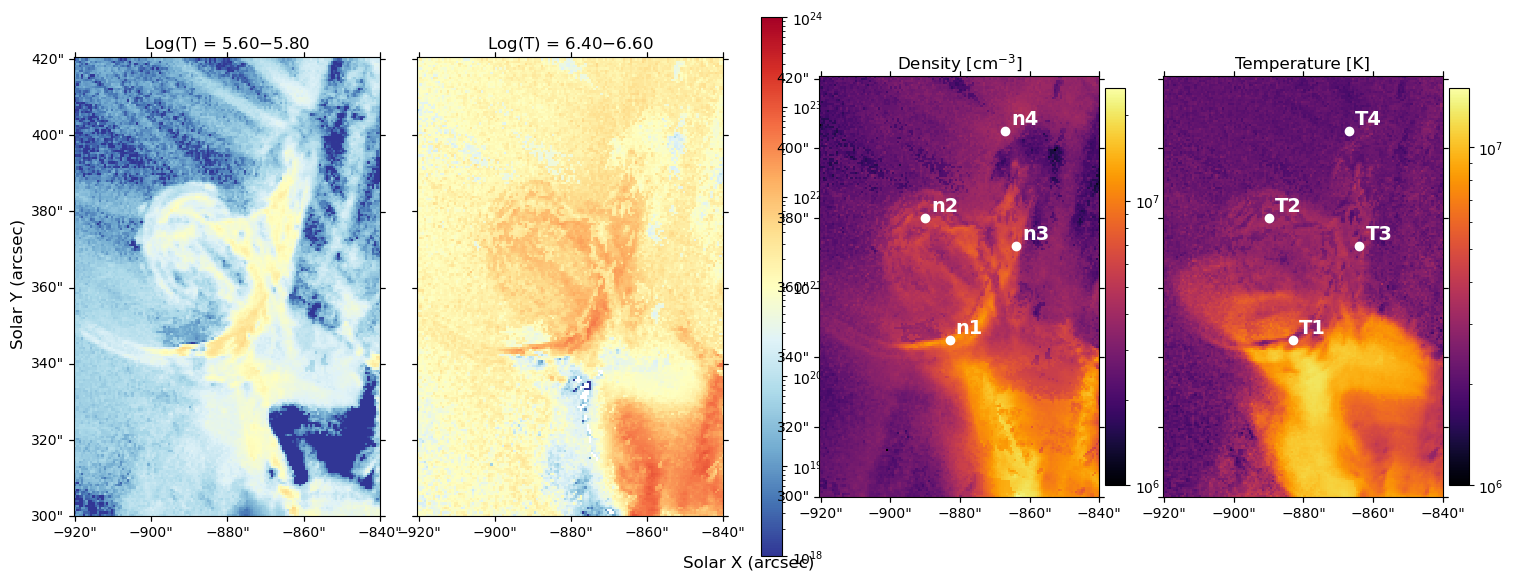

In [47]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.coordinates import SkyCoord
from matplotlib import colors

fig = plt.figure(figsize=[18, 7])
fig.supxlabel('Solar X (arcsec)', y=0.09)
fig.supylabel('Solar Y (arcsec)', x=0.09)

# Define GridSpec for layout
gs = GridSpec(1, 5, figure=fig, width_ratios=[1, 1, 0.07, 1, 1], wspace=0.15)

# First panel
ax1 = fig.add_subplot(gs[0], projection=plotmap1)
im1 = plotmap1.plot(
    axes=ax1,
    norm=colors.LogNorm(vmin=1e18, vmax=1e24),
    cmap='RdYlBu_r'
)
ax1.grid(False)
ax1.coords[0].set_axislabel(' ')
ax1.coords[1].set_axislabel(' ')
ax1.set_title(rf'Log(T) = {logtemps1[0]:.2f}$-${logtemps1[1]:.2f}')

# Second panel
ax2 = fig.add_subplot(gs[1], projection=plotmap2)
im2 = plotmap2.plot(
    axes=ax2,
    norm=colors.LogNorm(vmin=1e18, vmax=1e24),
    cmap='RdYlBu_r'
)
ax2.grid(False)
ax2.coords[0].set_axislabel(' ')
ax2.coords[1].set_axislabel(' ')
ax2.coords[1].set_ticklabel_visible(False)
ax2.set_title(rf'Log(T) = {logtemps2[0]:.2f}$-${logtemps2[1]:.2f}')

# Shared colorbar for first two panels
cax1 = fig.add_subplot(gs[2])
cbar1 = plt.colorbar(im2, cax=cax1,
                     # fraction=0.065,
                     shrink=0.5,
                     pad=0.02, label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')

# Third panel
ax3 = fig.add_subplot(gs[3], projection=plotdens)
im3 = plotdens.plot(
    axes=ax3,
    norm=colors.LogNorm(vmin=1e6, vmax=2.5e7),
    cmap='inferno'
)
for n_point in n_points:
    point_d_coord = SkyCoord(n_points[n_point][0], n_points[n_point][1], frame=plotdens.coordinate_frame)
    xd_pixel, yd_pixel = plotdens.wcs.world_to_pixel(point_d_coord)
    ax3.plot(xd_pixel, yd_pixel, 'wo')
    ax3.text(xd_pixel + 3, yd_pixel + 3, n_point, color='w', fontsize=14, weight='bold')
ax3.grid(False)
ax3.coords[0].set_axislabel(' ')
ax3.coords[1].set_axislabel(' ')
ax3.set_title(r'Density [cm$^{-3}$]')
plt.colorbar(im3, ax=ax3, fraction=0.065, pad=0.02)

# Fourth panel
ax4 = fig.add_subplot(gs[4], projection=plottemp)
im4 = plottemp.plot(
    axes=ax4,
    norm=colors.LogNorm(vmin=1e6, vmax=1.5e7),
    cmap='inferno'
)
for T_point in T_points:
    point_t_coord = SkyCoord(T_points[T_point][0], T_points[T_point][1], frame=plottemp.coordinate_frame)
    xt_pixel, yt_pixel = plottemp.wcs.world_to_pixel(point_t_coord)
    ax4.plot(xt_pixel, yt_pixel, 'wo')
    ax4.text(xt_pixel + 3, yt_pixel + 3, T_point, color='w', fontsize=14, weight='bold')
ax4.grid(False)
ax4.coords[0].set_axislabel(' ')
ax4.coords[1].set_axislabel(' ')
ax4.coords[1].set_ticklabel_visible(False)
ax4.set_title('Temperature [K]')
plt.colorbar(im4, ax=ax4, fraction=0.065, pad=0.02)

fig.tight_layout()
plt.show()